In [1]:
import os
import sys
import time
import h5py
import pygrib
import numpy as np
import netCDF4 as nc
from scipy.interpolate import interp2d
from datetime import datetime, timedelta

sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [65]:
def norm_precip(x):
    return np.log(x+1)

def norm_rh(x):
    return 2*(x/100 - 0.5)

def norm_t(x):
    return (x-282.8)/16.2/2

def norm_u(x):
    return (x-0.67)/5.8/2

def norm_pwat(x):
    return (x-20.5)/16.3/2

def norm_cape(x):
    return x-101.4/328/2

In [66]:
BATCH_dir

'/glade/campaign/cisl/aiml/ksha/BATCH_ERA5/'

**Batch gen 2021**

In [67]:
BATCH_dir = '/glade/campaign/cisl/aiml/ksha/BATCH_ERA5/'

year = 2021

size_mrms = 128
size_half = 64
gap = 64 # samples will have at least 5 non-overlap grids on height and width dimensions 
thres_dry = 1.0 # 1.0 mm = rain on that grid
thres_rain_cover = 0.33 # at least 25% of the grids should have rain
thres_land_cover = 0.90 # at least 90% of the grids should stay within land
thres_extreme = 30 # if a grid has 20 mm/hr or above, the sample will bypass "thres_rain_cover"
thres_extreme_cover = 0.05 # if a grid has 20 mm/hr or above, the sample will bypass "thres_rain_cover"

In [68]:
base = datetime(year, 1, 1)
date_list = [base + timedelta(hours=day) for day in range(365*24)]

In [125]:
with h5py.File(save_dir+'MRMS_ERA5_domain.hdf', 'r') as h5io:
    lon_ERA5 = h5io['lon_ERA5'][...]
    lat_ERA5 = h5io['lat_ERA5'][...]
    lon_MRMS = h5io['lon_MRMS'][...]
    lat_MRMS = h5io['lat_MRMS'][...]
    land_mask_MRMS = h5io['land_mask_MRMS'][...]
    elev_MRMS = h5io['elev_MRMS'][...]
    indx = h5io['MRMS_to_ERA5_indx'][...]
    indy = h5io['MRMS_to_ERA5_indy'][...]

elev_MRMS[elev_MRMS<0] = 0
elev_MRMS = elev_MRMS/2000 - 1

In [126]:
np.max(elev_MRMS)

1.0354999181186284

In [70]:
with h5py.File(save_dir+'MRMS_RQI_example.hdf', 'r') as h5io:
    RQI = h5io['RQI'][...]

**generating batches**

In [71]:
x_mrms = 3500
y_mrms = 7000
N_grids = size_mrms*size_mrms
batch_file_name = 'ERA5_y{:04d}_dt{:04d}_i{:04d}_j{:04d}.npy'

In [97]:
x_ERA5 = 361
y_ERA5 = 721

x_lr6 = np.linspace(0, 1, 6)
x_lr7 = np.linspace(0, 1, 7)
x_hr = x_hr128 = np.linspace(0, 1, 128)

nc_name_t = ERA5_dir+'ERA5_t2m_2021_bottom_layers.nc'
nc_name_u = ERA5_dir+'ERA5_u_2021_bottom_layers.nc'
nc_name_rh = ERA5_dir+'ERA5_rh_2021_bottom_layers.nc'
nc_name_apcp = ERA5_dir+'ERA5_APCP_2021.nc' #tp m (not mm)
nc_name_pwat = ERA5_dir+'ERA5_PWAT_2021.nc' # tcw kg m**-2 (= mm)
nc_name_cape = ERA5_dir+'ERA5_CAPE_2021.nc' # cape

batch_file_name = 'ERA5_year{:04d}_dt{:04d}_i{:04d}_j{:04d}.npy'

data = np.empty((1, size_mrms, size_mrms, 9))
# 0MRMS HR precip
# 1MRMS LR precip
# 2ERA5 Precip
# 3CAPE
# 4PWAT
# 5RH
# 6U
# 7T
# 8elev

with nc.Dataset(nc_name_apcp) as ncio_apcp:
    with nc.Dataset(nc_name_pwat) as ncio_pwat:
        with nc.Dataset(nc_name_cape) as ncio_cape:
            with nc.Dataset(nc_name_t) as ncio_t:
                with nc.Dataset(nc_name_u) as ncio_u:
                    with nc.Dataset(nc_name_rh) as ncio_rh:
                        # Main section
                        for i_dt, dt in enumerate(date_list[:1]):
                            dt_str = datetime.strftime(dt, '%Y%m%d-%H%M%S')
                            name_ = 'MRMS_MultiSensor_QPE_01H_Pass2_00.00_{}.grib2'.format(dt_str)
                            filename = MRMS_dir + name_
                            
                            if os.path.isfile(filename):
                                with pygrib.open(filename) as grbio:
                                    MRMS = grbio[1].values
                                # flip --> lower latitude at the bottom
                                MRMS = np.flipud(MRMS)
                        
                                for i_mrms in range(0, x_mrms-size_mrms+gap, gap):
                                    for j_mrms in range(0, y_mrms-size_mrms+gap, gap):
                                        i0 = i_mrms; i1 = i0 + size_mrms
                                        j0 = j_mrms; j1 = j0 + size_mrms

                                        if (np.sum(RQI[i0:i1, j0:j1]) < 0.75) == 0:
                                        
                                            patch_ = MRMS[i0:i1, j0:j1]
                                            land_mask_ = land_mask_MRMS[i0:i1, j0:j1]
                
                                            r_rain = np.sum(patch_ > thres_dry)/N_grids
                                            
                                            flag_size = patch_.shape == (size_mrms, size_mrms)
                                            flag_rain_cover = r_rain >= thres_rain_cover
                                            flag_land_cover = (np.sum(land_mask_)/N_grids) >= thres_land_cover
                                            flag_extreme = np.logical_and(np.max(patch_) >= thres_extreme, r_rain >= thres_extreme_cover)
                            
                                            flag_pass1 = np.logical_and(flag_rain_cover, flag_land_cover)
                                            flag_pass2 = np.logical_and(flag_extreme, flag_land_cover)
                                            flag_pass_final = np.logical_or(flag_pass1, flag_pass2)
                            
                                            if flag_size and flag_pass_final:
                
                                                elev_ = elev_MRMS[i0:i1, j0:j1]
                                                data[0, ..., 8] = elev_
                                                
                                                data[0, ..., 0] = patch_
                                                
                                                i_era = indx[i0:i1, j0:j1]
                                                j_era = indy[i0:i1, j0:j1]
                
                                                i_min = np.int(np.min(i_era))
                                                i_max = np.int(np.max(i_era))
                                                j_min = np.int(np.min(j_era))
                                                j_max = np.int(np.max(j_era))
                                                
                                                data_t = np.flipud(ncio_t['t'][i_dt, -8, i_min:i_max+1, j_min:j_max+1])
                                                
                                                shape_lr = data_t.shape
                                                if shape_lr[0] == 6:
                                                    x_ = x_lr6
                                                else:
                                                    x_ = x_lr7
                                                
                                                if shape_lr[1] == 6:
                                                    y_ = x_lr6
                                                else:
                                                    y_ = x_lr7
                                                
                                                interp_obj_t = interp2d(y_, x_, data_t, kind='linear')
                                                data[0, ..., 7] = interp_obj_t(x_hr128, x_hr128)
                
                                                data_u = np.flipud(ncio_u['u'][i_dt, -8, i_min:i_max+1, j_min:j_max+1])
                                                interp_obj_u = interp2d(y_, x_, data_u, kind='linear')
                                                data[0, ..., 6] = interp_obj_u(x_hr128, x_hr128)
                
                                                data_r = np.flipud(ncio_rh['r'][i_dt, -8, i_min:i_max+1, j_min:j_max+1])
                                                interp_obj_r = interp2d(y_, x_, data_r, kind='linear')
                                                data[0, ..., 5] = interp_obj_r(x_hr128, x_hr128)

                                                data_pwat = np.flipud(ncio_pwat['tcw'][i_dt, i_min:i_max+1, j_min:j_max+1])
                                                interp_obj_pwat = interp2d(y_, x_, data_pwat, kind='linear')
                                                data[0, ..., 4] = interp_obj_pwat(x_hr128, x_hr128)

                                                data_cape = np.flipud(ncio_cape['cape'][i_dt, i_min:i_max+1, j_min:j_max+1])
                                                interp_obj_cape = interp2d(y_, x_, data_cape, kind='linear')
                                                data[0, ..., 3] = interp_obj_cape(x_hr128, x_hr128)
                
                                                data_apcp = np.flipud(ncio_apcp['tp'][i_dt, i_min:i_max+1, j_min:j_max+1])
                                                data_apcp = data_apcp*1000
                                                interp_obj_apcp = interp2d(y_, x_, data_apcp, kind='linear')
                                                data[0, ..., 2] = interp_obj_apcp(x_hr128, x_hr128)

                                                hr_to_lr = interp2d(x_hr, x_hr, data[0, ..., 0], kind='linear')
                                                data_lr = hr_to_lr(y_, x_)
                                                lr_to_hr = interp2d(y_, x_, data_lr, kind='linear')
                                                data_hr = lr_to_hr(x_hr, x_hr)

                                                data[0, ..., 1] = data_hr
                                                
                                                data[0, ..., 0] = norm_precip(data[0, ..., 0])
                                                data[0, ..., 1] = norm_precip(data[0, ..., 1])
                                                data[0, ..., 2] = norm_precip(data[0, ..., 2])
                                                data[0, ..., 3] = norm_cape(data[0, ..., 3])
                                                data[0, ..., 4] = norm_pwat(data[0, ..., 4])
                                                data[0, ..., 5] = norm_rh(data[0, ..., 5])
                                                data[0, ..., 6] = norm_u(data[0, ..., 6])
                                                data[0, ..., 7] = norm_t(data[0, ..., 7])

                                                flag_save = True
                                                for i_test in range(5):
                                                    temp = np.abs(data[0, ..., 3+i_test])
                                                    if np.sum(temp > 1e-6) == 0:
                                                        flag_save = False
                                                        
                                                if flag_save:
                                                    name_ = BATCH_dir+batch_file_name.format(year, i_dt, i_mrms, j_mrms)
                                                    print(name_)
                                                    np.save(name_, data)

/glade/campaign/cisl/aiml/ksha/BATCH_ERA5/ERA5_year2021_dt0000_i0704_j4096.npy
/glade/campaign/cisl/aiml/ksha/BATCH_ERA5/ERA5_year2021_dt0000_i0768_j4096.npy
/glade/campaign/cisl/aiml/ksha/BATCH_ERA5/ERA5_year2021_dt0000_i0768_j4160.npy
/glade/campaign/cisl/aiml/ksha/BATCH_ERA5/ERA5_year2021_dt0000_i0832_j3520.npy
/glade/campaign/cisl/aiml/ksha/BATCH_ERA5/ERA5_year2021_dt0000_i0832_j3584.npy
/glade/campaign/cisl/aiml/ksha/BATCH_ERA5/ERA5_year2021_dt0000_i0832_j4096.npy
/glade/campaign/cisl/aiml/ksha/BATCH_ERA5/ERA5_year2021_dt0000_i0832_j4160.npy
/glade/campaign/cisl/aiml/ksha/BATCH_ERA5/ERA5_year2021_dt0000_i0832_j4224.npy
/glade/campaign/cisl/aiml/ksha/BATCH_ERA5/ERA5_year2021_dt0000_i0832_j4288.npy
/glade/campaign/cisl/aiml/ksha/BATCH_ERA5/ERA5_year2021_dt0000_i0896_j3520.npy
/glade/campaign/cisl/aiml/ksha/BATCH_ERA5/ERA5_year2021_dt0000_i0896_j3584.npy
/glade/campaign/cisl/aiml/ksha/BATCH_ERA5/ERA5_year2021_dt0000_i0896_j3904.npy
/glade/campaign/cisl/aiml/ksha/BATCH_ERA5/ERA5_year2

In [78]:
with nc.Dataset(nc_name_cape) as ncio_cape:
    data_cape = np.flipud(ncio_cape['cape'][::24, ...])

In [79]:
np.mean(data_cape)

101.41392627132522

In [80]:
np.std(data_cape)

328.10754630379495

In [77]:
data_cape.shape

(7, 6)

In [30]:
# plt.pcolormesh(data_t, cmap=plt.cm.jet)
# plt.colorbar()

In [109]:
data = np.load('/glade/campaign/cisl/aiml/ksha/BATCH_ERA5/ERA5_year2021_dt0000_i1344_j3328.npy')

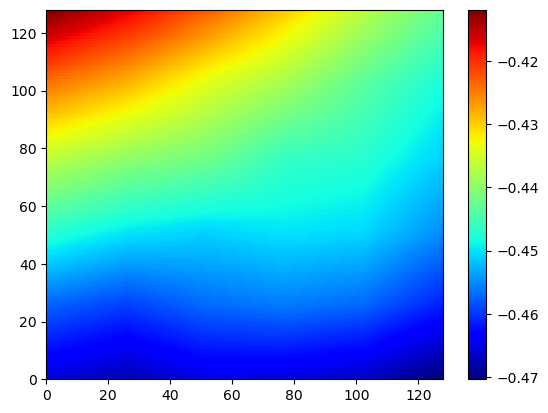

In [122]:
plt.pcolormesh(data[0, ..., 4], cmap=plt.cm.jet)
plt.colorbar()

In [121]:
data[0, ..., 3]

array([[-0.15457317, -0.15457317, -0.15457317, ..., -0.15457317,
        -0.15457317, -0.15457317],
       [-0.15457317, -0.15457317, -0.15457317, ..., -0.15457317,
        -0.15457317, -0.15457317],
       [-0.15457317, -0.15457317, -0.15457317, ..., -0.15457317,
        -0.15457317, -0.15457317],
       ...,
       [-0.15457317, -0.15457317, -0.15457317, ..., -0.15457317,
        -0.15457317, -0.15457317],
       [-0.15457317, -0.15457317, -0.15457317, ..., -0.15457317,
        -0.15457317, -0.15457317],
       [-0.15457317, -0.15457317, -0.15457317, ..., -0.15457317,
        -0.15457317, -0.15457317]])

In [42]:
data[0, ..., 3]

array([[6.06329801e-13, 6.06329801e-13, 6.06329801e-13, ...,
        6.06329801e-13, 6.06329801e-13, 6.06329801e-13],
       [6.06329801e-13, 6.06329801e-13, 6.06329801e-13, ...,
        6.06329801e-13, 6.06329801e-13, 6.06329801e-13],
       [6.06329801e-13, 6.06329801e-13, 6.06329801e-13, ...,
        6.06329801e-13, 6.06329801e-13, 6.06329801e-13],
       ...,
       [6.06329801e-13, 6.06329801e-13, 6.06329801e-13, ...,
        6.06329801e-13, 6.06329801e-13, 6.06329801e-13],
       [6.06329801e-13, 6.06329801e-13, 6.06329801e-13, ...,
        6.06329801e-13, 6.06329801e-13, 6.06329801e-13],
       [6.06329801e-13, 6.06329801e-13, 6.06329801e-13, ...,
        6.06329801e-13, 6.06329801e-13, 6.06329801e-13]])

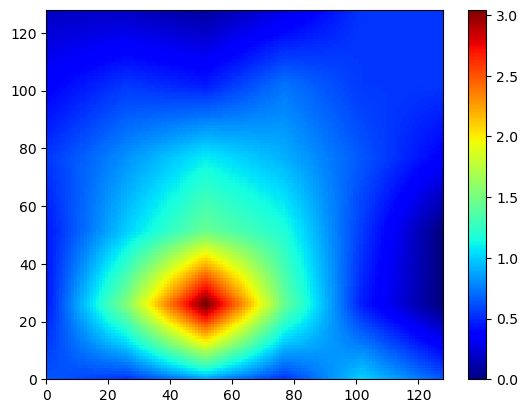

In [72]:
plt.pcolormesh(data[0, ..., 3], cmap=plt.cm.jet)
plt.colorbar()

In [18]:
lon_MRMS[i0:i1, j0:j1]

array([[-60.87500198, -60.86500198, -60.85500198, ..., -60.025002  ,
        -60.015002  , -60.005002  ],
       [-60.87500198, -60.86500198, -60.85500198, ..., -60.025002  ,
        -60.015002  , -60.005002  ],
       [-60.87500198, -60.86500198, -60.85500198, ..., -60.025002  ,
        -60.015002  , -60.005002  ],
       ...,
       [-60.87500198, -60.86500198, -60.85500198, ..., -60.025002  ,
        -60.015002  , -60.005002  ],
       [-60.87500198, -60.86500198, -60.85500198, ..., -60.025002  ,
        -60.015002  , -60.005002  ],
       [-60.87500198, -60.86500198, -60.85500198, ..., -60.025002  ,
        -60.015002  , -60.005002  ]])

In [23]:
i = 300
j = 450

print('{} vs. {}'.format(lon_MRMS[i, j], lon_ERA5[int(indx[i, j]), int(indy[i, j])]))

-125.49500012859244 vs. -125.5


In [27]:
lon_ERA5[276, 476]

-61.0

In [25]:
indx[i0:i1, j0:j1]

array([[276., 276., 276., ..., 276., 276., 276.],
       [276., 276., 276., ..., 276., 276., 276.],
       [276., 276., 276., ..., 276., 276., 276.],
       ...,
       [280., 280., 280., ..., 280., 280., 280.],
       [280., 280., 280., ..., 280., 280., 280.],
       [280., 280., 280., ..., 280., 280., 280.]])

In [29]:
indx[i0:i1, j0:j1]

array([[276., 276., 276., ..., 276., 276., 276.],
       [276., 276., 276., ..., 276., 276., 276.],
       [276., 276., 276., ..., 276., 276., 276.],
       ...,
       [280., 280., 280., ..., 280., 280., 280.],
       [280., 280., 280., ..., 280., 280., 280.],
       [280., 280., 280., ..., 280., 280., 280.]])

In [26]:
indy[i0:i1, j0:j1]

array([[476., 477., 477., ..., 480., 480., 480.],
       [476., 477., 477., ..., 480., 480., 480.],
       [476., 477., 477., ..., 480., 480., 480.],
       ...,
       [476., 477., 477., ..., 480., 480., 480.],
       [476., 477., 477., ..., 480., 480., 480.],
       [476., 477., 477., ..., 480., 480., 480.]])

In [28]:
i_era

array([[201., 201., 201., ..., 201., 201., 201.],
       [201., 201., 201., ..., 201., 201., 201.],
       [202., 202., 202., ..., 202., 202., 202.],
       ...,
       [206., 206., 206., ..., 206., 206., 206.],
       [206., 206., 206., ..., 206., 206., 206.],
       [207., 207., 207., ..., 207., 207., 207.]])

In [30]:
i_min

201